In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import ast
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Universal device selection for both Mac (MPS) and NVIDIA (CUDA) GPUs
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA GPU: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Metal Performance Shaders) on Mac GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

print(f"Device: {device}")

Using MPS (Metal Performance Shaders) on Mac GPU
Device: mps


# A. Task 1: Data Preparation and Preprocessing

In [2]:
def load_data(from_cache:bool = True, csv_path:str = 'labeled_dataset.csv', dataset_root:str = './2025_Dataset') -> any:
    """
    Loads dataset from either a cached CSV file or by scanning the raw dataset directory.

    This function supports two modes:
    - If `from_cache` is True, it loads the dataset from a pre-saved CSV file.
    - If `from_cache` is False, it scans the '2025_Dataset' directory for image and depth data,
      parses the folder names to extract pitch and roll values, and saves the processed data
      into a CSV file for future use.

    The dataset is expected to be organized in folders following the naming convention:
    `P<pitch>_R<roll>`, where each folder contains a depth file named `<folder_name>_depth.txt`.
    Each line in the depth file is expected to be a tuple string of the form:
    `('filename.jpg', depth_value)`.

    Parameters:
    -----------
    from_cache : bool, optional
        If True, loads data from the CSV file specified by `csv_path`. 
        If False, scans the '2025_Dataset' directory and saves data to `csv_path`.
        Default is True.

    csv_path : str, optional
        Path to the CSV file for caching or loading data. Default is 'labeled_dataset.csv'.
        
    dataset_root : str, optional
        Path to the dataset folder. Default is '2025_Dataset'.

    Returns:
    --------
    pandas.DataFrame or None
        If `from_cache` is True, returns a DataFrame loaded from the CSV file.
        If `from_cache` is False, returns the DataFrame after processing and saving to CSV,
        and also prints summary statistics.

    Raises:
    -------
    FileNotFoundError
        If the '2025_Dataset' directory is not found.

    Notes:
    ------
    - The function assumes the notebook is run from the 'Course Work' directory.
    - When `from_cache` is False, the function saves the processed data to a CSV file
      and prints information about total images processed and sample rows.
    """
    if from_cache == False:
        # Define the root directory of the dataset relative to the notebook
        data = []

        # Check if dataset directory exists
        if not os.path.exists(dataset_root):
            print(f"Error: Dataset directory '{dataset_root}' not found. Please ensure you are running this notebook from the 'Course Work' directory.")
        else:
            print(f"Scanning dataset in '{dataset_root}'...")
            
            # Walk through the dataset directory
            for folder_name in sorted(os.listdir(dataset_root)):
                folder_path = os.path.join(dataset_root, folder_name)
                
                # Check if it's a directory and follows the Px_Ry pattern
                if os.path.isdir(folder_path) and folder_name.startswith('P') and '_R' in folder_name:
                    try:
                        # Parse Pitch and Roll from folder name (e.g., P0_R0 -> Pitch=0, Roll=0)
                        parts = folder_name.split('_')
                        pitch = int(parts[0][1:]) # Remove 'P'
                        roll = int(parts[1][1:])  # Remove 'R'
                        
                        # Find the depth file (e.g., P0_R0_depth.txt)
                        depth_files = [f for f in os.listdir(folder_path) if f.endswith('_depth.txt')]
                        
                        if depth_files:
                            depth_file_path = os.path.join(folder_path, depth_files[0])
                            
                            with open(depth_file_path, 'r') as f:
                                for line in f:
                                    # The line format is "('filename.jpg', depth_value)"
                                    line = line.strip()
                                    if not line: continue
                                    
                                    try:
                                        # Safely parse the tuple string
                                        img_name, depth_val = ast.literal_eval(line)
                                        
                                        # Construct relative path
                                        # Note: The DataFrame will store the path relative to the notebook/dataset root
                                        rel_path = os.path.join(dataset_root, folder_name, img_name)
                                        
                                        data.append({
                                            'relative_path': rel_path,
                                            'image_name': img_name,
                                            'pitch': pitch,
                                            'roll': roll,
                                            'depth': depth_val
                                        })
                                    except Exception as e:
                                        print(f"Error parsing line in {depth_files[0]}: {line} - {e}")
                    except Exception as e:
                        print(f"Error processing folder {folder_name}: {e}")
            # Create DataFrame
            df = pd.DataFrame(data)

            # Save to CSV
            df.to_csv(csv_path, index=False)
            return df
    else:
        return pd.read_csv(csv_path)

    print(f"Dataset processing complete. Saved to {csv_path}")
    print(f"Total images processed: {len(df)}")
    print(df.head())

df = load_data(from_cache=False)
df.head()

Scanning dataset in './2025_Dataset'...


,relative_path,image_name,pitch,roll,depth
0,./2025_Dataset/P0_R0/video_14_stable_bot_l6s3_...,video_14_stable_bot_l6s3_P0_R0_00219.jpg,0,0,0.785
1,./2025_Dataset/P0_R0/video_14_stable_bot_l6s3_...,video_14_stable_bot_l6s3_P0_R0_00222.jpg,0,0,0.686
2,./2025_Dataset/P0_R0/video_14_stable_bot_l6s3_...,video_14_stable_bot_l6s3_P0_R0_00228.jpg,0,0,0.991
3,./2025_Dataset/P0_R0/video_14_stable_bot_l6s3_...,video_14_stable_bot_l6s3_P0_R0_00120.jpg,0,0,0.103
4,./2025_Dataset/P0_R0/video_14_stable_bot_l6s3_...,video_14_stable_bot_l6s3_P0_R0_00198.jpg,0,0,0.931


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


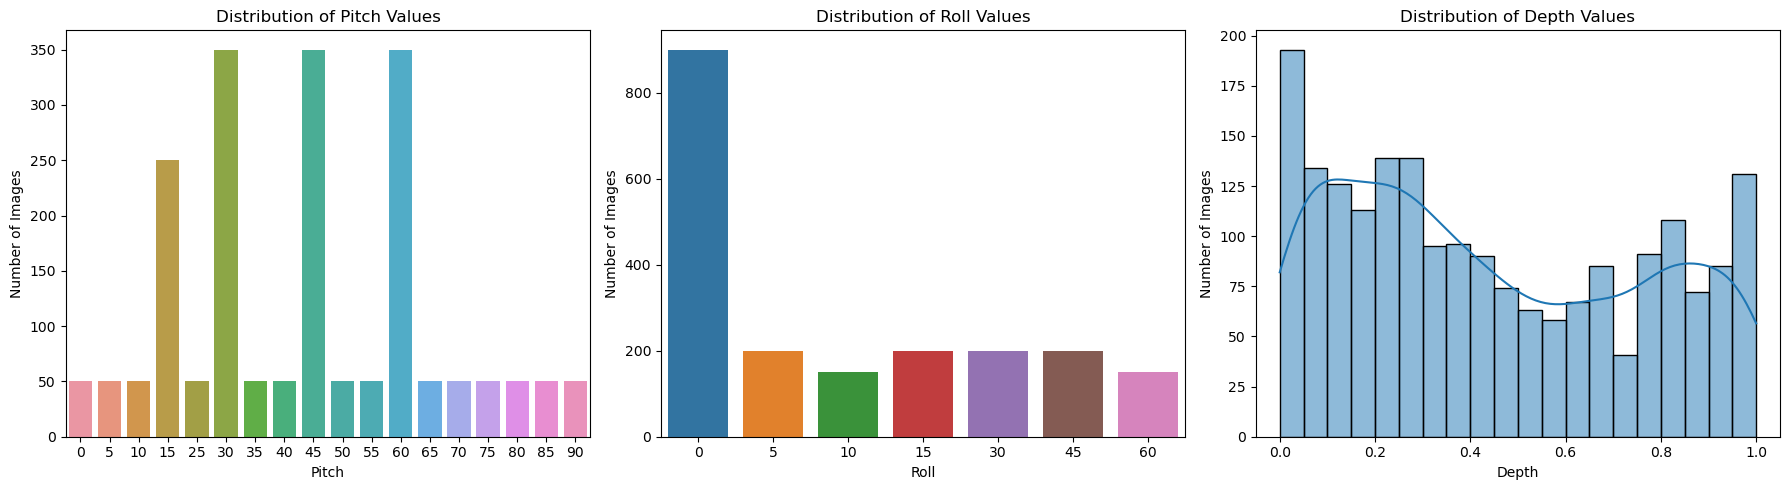

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# show 3 images
for i, col in enumerate(['pitch', 'roll']):
    sns.countplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f'Distribution of {col.capitalize()} Values')
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel('Number of Images')

# depth separately
sns.histplot(data=df, x='depth', bins=20, kde=True, ax=axes[2])
axes[2].set_title('Distribution of Depth Values')
axes[2].set_xlabel('Depth')
axes[2].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

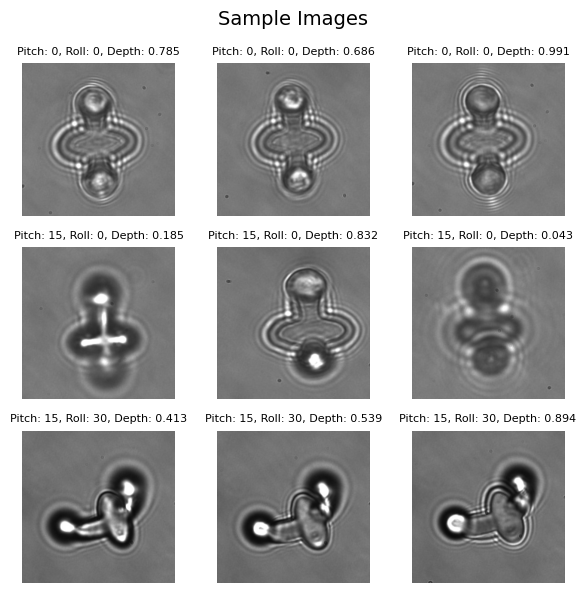

In [4]:
width, height = 3, 3
jump = 35

fig, axes = plt.subplots(height, width, figsize=(width*2, height*2))
fig.suptitle('Sample Images', fontsize=14)

for i in range(height):
    for j in range(width):
        img_path = df.iloc[i*width*jump + j]['relative_path']
        img = plt.imread(img_path)
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"Pitch: {df.iloc[i*width*jump + j]['pitch']}, Roll: {df.iloc[i*width*jump + j]['roll']}, Depth: {df.iloc[i*width*jump + j]['depth']}", fontsize=8)
        axes[i, j].axis('off')  

plt.tight_layout()
plt.show()


In [5]:
# from skimage import exposure

def normalize_image(img, method='minmax'):
    """
    Normalize image pixel intensities using various methods.
    ---------
    Simple: scales by dividing by 225

    Min-Max: scales pixel values to [0, 1] based on min and max of the image.

    Standard: standardizes pixel values to have zero mean and unit variance, then clips to [-3, 3] and scales to [0, 1].
    """
    
    if method == 'simple':  # Simple does not visibly change anything about the image.
                            # Sticking to this for now but will see if others improve performance.
        # Simple normalization to [0, 1] 
        return img / 255.0
    
    elif method == 'minmax':
        # Min-Max normalization per image (stretches contrast)
        img_min = img.min()
        img_max = img.max()
        if img_max - img_min == 0:
            return img / 255.0
        return (img - img_min) / (img_max - img_min)
    
    elif method == 'standard':
        # Standardization (zero mean, unit variance)
        mean = img.mean()
        std = img.std()
        if std == 0:
            return img / 255.0
        normalized = (img - mean) / std
        # Clip to reasonable range and scale to [0, 1]
        normalized = np.clip(normalized, -3, 3)
        return (normalized + 3) / 6
    
    
    else:
        return img / 255.0



In [6]:
# # Reset norm folder
# import glob
# import os

# files = glob.glob('./2025_Dataset_norm/**/norm_*', recursive=True)
# for f in files:
#     os.remove(f)
# print(f"Deleted {len(files)} files starting with 'norm_'")


In [58]:
CREATE_NEW=True

# create a new dataset for normalized images
normalized_data = []
for index, row in df.iterrows():
    img_path = row['relative_path']
    img = plt.imread(img_path)
    normalized_img = normalize_image(img, method='minmax')
    
    if CREATE_NEW:
        # Save normalized image to a new path in the 2025_Dataset_minmax folder
        norm_img_name = f"norm_{row['image_name']}"
        norm_img_path = os.path.join('./2025_Dataset_minmax', norm_img_name)
        plt.imsave(norm_img_path, normalized_img)
    else:
        norm_img_name = f"norm_{row['image_name']}"
        norm_img_path = os.path.join('2025_Dataset_minmax', norm_img_name)
    
    normalized_data.append({
        'relative_path': norm_img_path,
        'image_name': norm_img_name,
        'pitch': row['pitch'],
        'roll': row['roll'],
        'depth': row['depth']
    })

In [59]:
# turn the normalised data into a df
normalized_df = pd.DataFrame(normalized_data)
normalized_df.head()

# Minmax the depth values
scaler = MinMaxScaler()
normalized_df['minmax_depth'] = scaler.fit_transform(normalized_df[['depth']])
normalized_df.head()

,relative_path,image_name,pitch,roll,depth,minmax_depth
0,./2025_Dataset_minmax/norm_video_14_stable_bot...,norm_video_14_stable_bot_l6s3_P0_R0_00219.jpg,0,0,0.785,0.785
1,./2025_Dataset_minmax/norm_video_14_stable_bot...,norm_video_14_stable_bot_l6s3_P0_R0_00222.jpg,0,0,0.686,0.686
2,./2025_Dataset_minmax/norm_video_14_stable_bot...,norm_video_14_stable_bot_l6s3_P0_R0_00228.jpg,0,0,0.991,0.991
3,./2025_Dataset_minmax/norm_video_14_stable_bot...,norm_video_14_stable_bot_l6s3_P0_R0_00120.jpg,0,0,0.103,0.103
4,./2025_Dataset_minmax/norm_video_14_stable_bot...,norm_video_14_stable_bot_l6s3_P0_R0_00198.jpg,0,0,0.931,0.931


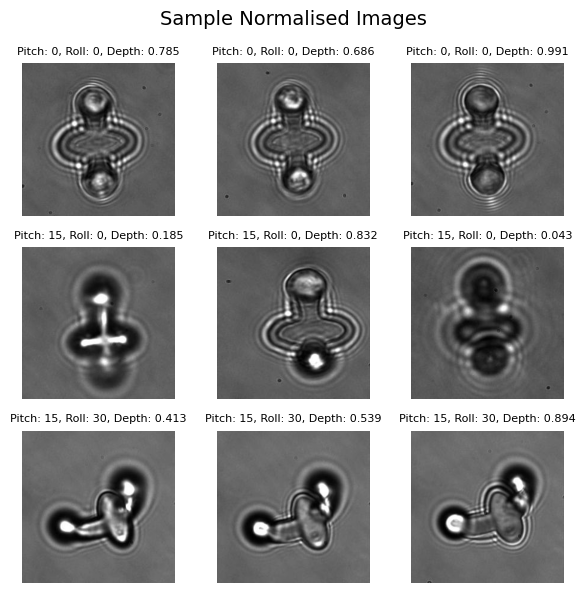

In [60]:
width, height = 3, 3
jump = 35

fig, axes = plt.subplots(height, width, figsize=(width*2, height*2))
fig.suptitle('Sample Normalised Images', fontsize=14)

for i in range(height):
    for j in range(width):
        img_path = normalized_df.iloc[i*width*jump + j]['relative_path']
        img = plt.imread(img_path)
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"Pitch: {normalized_df.iloc[i*width*jump + j]['pitch']}, Roll: {normalized_df.iloc[i*width*jump + j]['roll']}, Depth: {normalized_df.iloc[i*width*jump + j]['depth']}", fontsize=8)
        axes[i, j].axis('off')  

plt.tight_layout()
plt.show()

# # Non-normalised images for comparison
# fig, axes = plt.subplots(height, width, figsize=(width*2, height*2))
# fig.suptitle('Sample Images', fontsize=14)

# for i in range(height):
#     for j in range(width):
#         img_path = df.iloc[i*width*jump + j]['relative_path']
#         img = plt.imread(img_path)
#         axes[i, j].imshow(img)
#         axes[i, j].set_title(f"Pitch: {df.iloc[i*width*jump + j]['pitch']}, Roll: {df.iloc[i*width*jump + j]['roll']}, Depth: {df.iloc[i*width*jump + j]['depth']}", fontsize=8)
#         axes[i, j].axis('off')  

# plt.tight_layout()
# plt.show()

# Data split

In [61]:
# Spliting into train (60%) and temp (40%), then temp into val (20%) and test (20%)

train_df, temp_df = train_test_split(normalized_df, test_size=0.4, stratify=normalized_df[['pitch', 'roll']], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df[['pitch', 'roll']], random_state=42)


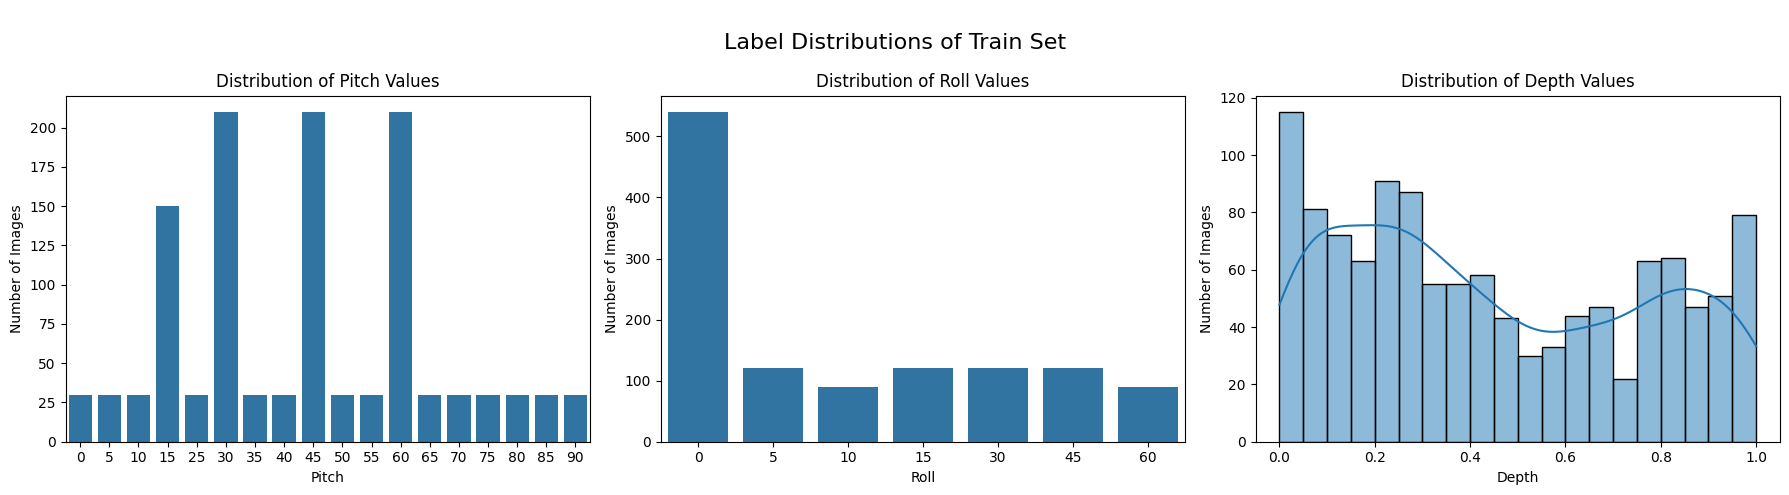

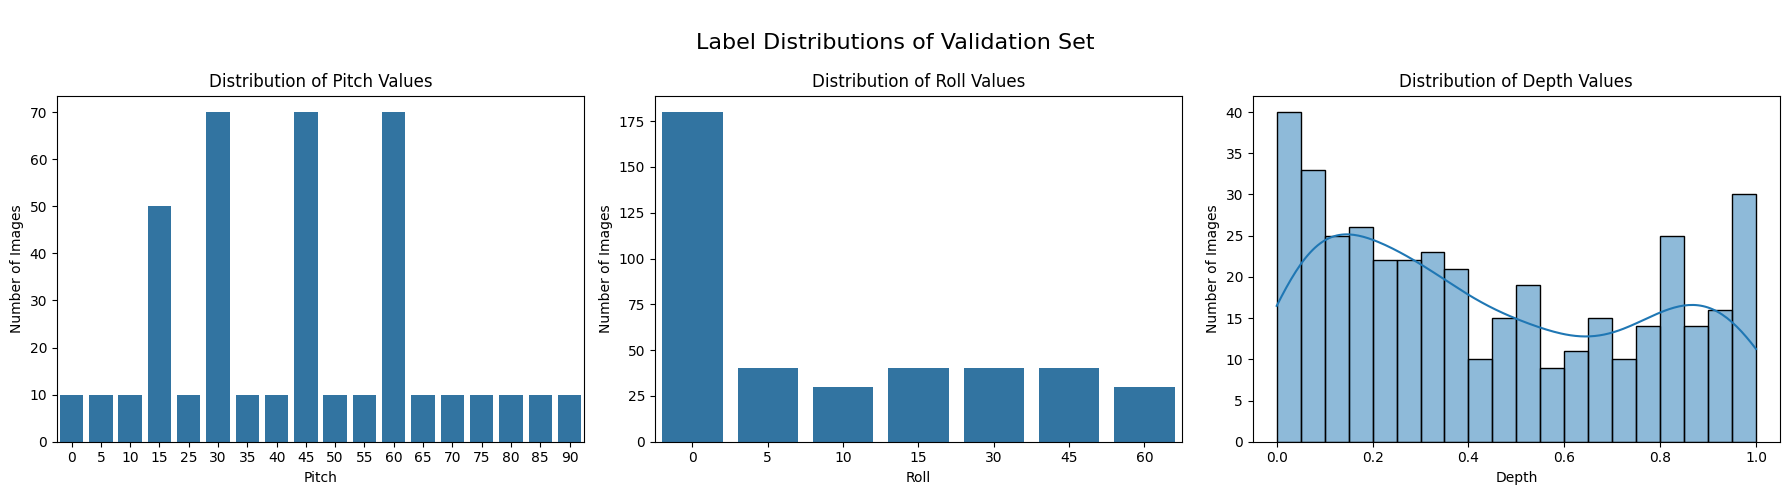

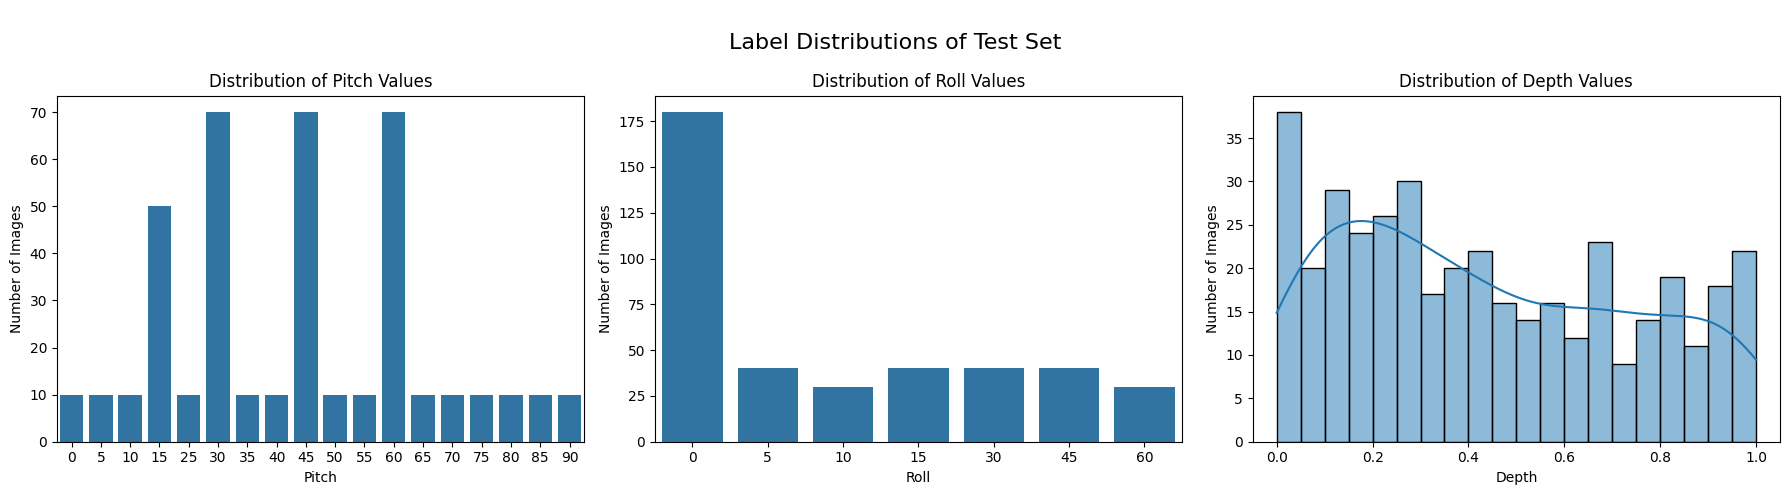

In [62]:
# Analyze label distributions in each set
for data, name in [(train_df, "Train"), (val_df, "Validation"), (test_df, "Test")]: # for each set

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"\nLabel Distributions of {name} Set", fontsize=16)

    # Pitch & Roll
    for i, col in enumerate(['pitch', 'roll']):
        sns.countplot(data=data, x=col, ax=axes[i])
        axes[i].set_title(f'Distribution of {col.capitalize()} Values')
        axes[i].set_xlabel(col.capitalize())
        axes[i].set_ylabel('Number of Images')

    # Depth Separately
    sns.histplot(data=data, x='depth', bins=20, kde=True, ax=axes[2])
    axes[2].set_title('Distribution of Depth Values')
    axes[2].set_xlabel('Depth')
    axes[2].set_ylabel('Number of Images')

    plt.tight_layout()
    plt.show()

In [63]:
# make one label column for pitch and roll combined
train_df['label'] = train_df['pitch'].astype(str) + '_' + train_df['roll'].astype(str)
val_df['label'] = val_df['pitch'].astype(str) + '_' + val_df['roll'].astype(str)
test_df['label'] = test_df['pitch'].astype(str) + '_' + test_df['roll'].astype(str)

looks good :)

# B. Task 2: Pose Estimation (Classification)

In [64]:
# Create mappings from angle values to class indices
# This is necessary because CrossEntropyLoss expects class indices (0, 1, 2, ...) 
# but our data has raw angle values (0, 5, 10, 15, 20, ...)

pitch_values = sorted(normalized_df['pitch'].unique())
roll_values = sorted(normalized_df['roll'].unique())

pitch_to_idx = {val: idx for idx, val in enumerate(pitch_values)}
roll_to_idx = {val: idx for idx, val in enumerate(roll_values)}

# Reverse mappings for decoding predictions back to angle values
idx_to_pitch = {idx: val for val, idx in pitch_to_idx.items()}
idx_to_roll = {idx: val for val, idx in roll_to_idx.items()}

print(f"Pitch values: {pitch_values}")
print(f"Roll values: {roll_values}")
print(f"\nPitch mapping (angle → class index): {pitch_to_idx}")
print(f"Roll mapping (angle → class index): {roll_to_idx}")

Pitch values: [np.int64(0), np.int64(5), np.int64(10), np.int64(15), np.int64(25), np.int64(30), np.int64(35), np.int64(40), np.int64(45), np.int64(50), np.int64(55), np.int64(60), np.int64(65), np.int64(70), np.int64(75), np.int64(80), np.int64(85), np.int64(90)]
Roll values: [np.int64(0), np.int64(5), np.int64(10), np.int64(15), np.int64(30), np.int64(45), np.int64(60)]

Pitch mapping (angle → class index): {np.int64(0): 0, np.int64(5): 1, np.int64(10): 2, np.int64(15): 3, np.int64(25): 4, np.int64(30): 5, np.int64(35): 6, np.int64(40): 7, np.int64(45): 8, np.int64(50): 9, np.int64(55): 10, np.int64(60): 11, np.int64(65): 12, np.int64(70): 13, np.int64(75): 14, np.int64(80): 15, np.int64(85): 16, np.int64(90): 17}
Roll mapping (angle → class index): {np.int64(0): 0, np.int64(5): 1, np.int64(10): 2, np.int64(15): 3, np.int64(30): 4, np.int64(45): 5, np.int64(60): 6}


In [65]:
# implement a dataloader for the datasets

class PoseDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['relative_path']
        image = plt.imread(img_path)
        # label = self.dataframe.iloc[idx]['label']
        pitch = self.dataframe.iloc[idx]['pitch']
        roll = self.dataframe.iloc[idx]['roll']

        # Convert raw angle values to class indices for CrossEntropyLoss
        pitch_idx = pitch_to_idx[pitch]
        roll_idx = roll_to_idx[roll]

        if self.transform:
            image = self.transform(image)

        return image, (pitch_idx, roll_idx)  # Return class indices, not raw angles

# Create datasets
train_dataset = PoseDataset(train_df, transform=ToTensor())
val_dataset = PoseDataset(val_df, transform=ToTensor())
test_dataset = PoseDataset(test_df, transform=ToTensor())

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check one batch
images, labels = next(iter(train_loader))
print(f"Batch image tensor shape: {images.shape}")
print(f"Batch labels tensor shape: {labels[0].shape}, {labels[1].shape}")
print(f"Sample labels (class indices): pitch={labels[0][:5]}, roll={labels[1][:5]}")
# print(f"Number of labels in batch: {len(labels)}")

Batch image tensor shape: torch.Size([32, 3, 256, 256])
Batch labels tensor shape: torch.Size([32]), torch.Size([32])
Sample labels (class indices): pitch=tensor([ 1, 11,  8, 11,  8]), roll=tensor([0, 6, 0, 4, 2])


In [66]:
# show train_dataset
train_images, train_labels = next(iter(train_loader))
print(f"Train Batch image tensor shape: {train_images.shape}")
print(f"Train Batch labels tensor shape: {train_labels[0].shape}, {train_labels[1].shape}")

Train Batch image tensor shape: torch.Size([32, 3, 256, 256])
Train Batch labels tensor shape: torch.Size([32]), torch.Size([32])


In [67]:
normalized_df['pitch'].nunique(), normalized_df['roll'].nunique()

(18, 7)

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim

class FirstCNN(nn.Module):
    def __init__(self, num_pitch_classes=18, num_roll_classes=7):
        super (FirstCNN, self).__init__()

        #conv layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.relu = nn.ReLU()

        # calculate the flattened size based on the input image size
        # input images are 256x256
        # adter 3 pooling layers, 256 -> 128 -> 64 -> 32

        # fully connected layers
        self.fc1 = nn.Linear(128 * 32 * 32, 128)
        self.dropout = nn.Dropout(0.5)

        # self.fc2 = nn.Linear(128, 36)  # 36 classes for combined pitch and roll
        self.pitch_head = nn.Linear(128, num_pitch_classes)
        self.roll_head = nn.Linear(128, num_roll_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)

        x = self.relu(self.fc1(x))
        x = self.dropout(x)

        pitch_output = self.pitch_head(x)
        roll_output = self.roll_head(x)

        return pitch_output, roll_output


In [69]:
model = FirstCNN(num_pitch_classes=normalized_df['pitch'].nunique(), num_roll_classes=normalized_df['roll'].nunique())

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training 

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    for images, (pitch_labels, roll_labels) in train_loader:
        images = images.to(device)
        pitch_labels = pitch_labels.to(device)
        roll_labels = roll_labels.to(device)

        pitch_outputs, roll_outputs = model(images)

        # calculate loss for both tasks
        loss_pitch = criterion(pitch_outputs, pitch_labels)
        loss_roll = criterion(roll_outputs, roll_labels)
        loss = loss_pitch + loss_roll

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item()

In [70]:
model.eval()
with torch.no_grad():
    pitch_logits, roll_logits = model(images)
    pitch_pred = torch.argmax(pitch_logits, dim=1)
    roll_pred = torch.argmax(roll_logits, dim=1)

In [71]:
# Move model to device
model = model.to(device)

# Evaluation function
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    pitch_correct = 0
    roll_correct = 0
    total_samples = 0
    
    all_pitch_preds = []
    all_pitch_labels = []
    all_roll_preds = []
    all_roll_labels = []
    
    with torch.no_grad():
        for images, (pitch_labels, roll_labels) in data_loader:
            images = images.to(device)
            pitch_labels = pitch_labels.to(device)
            roll_labels = roll_labels.to(device)
            
            pitch_outputs, roll_outputs = model(images)
            
            # Calculate loss
            loss_pitch = criterion(pitch_outputs, pitch_labels)
            loss_roll = criterion(roll_outputs, roll_labels)
            loss = loss_pitch + loss_roll
            total_loss += loss.item()
            
            # Get predictions
            pitch_pred = torch.argmax(pitch_outputs, dim=1)
            roll_pred = torch.argmax(roll_outputs, dim=1)
            
            # Calculate accuracy
            pitch_correct += (pitch_pred == pitch_labels).sum().item()
            roll_correct += (roll_pred == roll_labels).sum().item()
            total_samples += pitch_labels.size(0)
            
            # Store for confusion matrix
            all_pitch_preds.extend(pitch_pred.cpu().numpy())
            all_pitch_labels.extend(pitch_labels.cpu().numpy())
            all_roll_preds.extend(roll_pred.cpu().numpy())
            all_roll_labels.extend(roll_labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    pitch_accuracy = 100 * pitch_correct / total_samples
    roll_accuracy = 100 * roll_correct / total_samples
    
    return avg_loss, pitch_accuracy, roll_accuracy, all_pitch_preds, all_pitch_labels, all_roll_preds, all_roll_labels

In [74]:
import tqdm.auto as tqdm

In [75]:
# Training loop with validation
num_epochs = 30
train_losses = []
val_losses = []
val_pitch_accs = []
val_roll_accs = []

print("Starting training...")
print(f"{'Epoch':<6} {'Train Loss':<12} {'Val Loss':<12} {'Pitch Acc':<12} {'Roll Acc':<12}")
print("-" * 60)

for epoch in tqdm.tqdm(range(num_epochs)):
    # Training
    train_loss = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # Validation
    val_loss, pitch_acc, roll_acc, _, _, _, _ = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_pitch_accs.append(pitch_acc)
    val_roll_accs.append(roll_acc)
    
    print(f"{epoch+1:<6} {train_loss:<12.4f} {val_loss:<12.4f} {pitch_acc:<12.2f} {roll_acc:<12.2f}")

print("\nTraining complete!")

Starting training...
Epoch  Train Loss   Val Loss     Pitch Acc    Roll Acc    
------------------------------------------------------------


  0%|          | 0/30 [00:00<?, ?it/s]

1      2.3112       1.5836       60.75        90.00       
2      1.4006       1.1554       72.00        91.00       
3      1.2548       0.9949       74.00        92.50       
4      0.7734       0.8213       75.50        93.00       
5      0.8268       0.6636       79.75        95.00       
6      1.0710       0.7285       80.00        93.50       
7      1.0864       0.6168       85.00        94.50       
8      1.2625       0.5539       85.75        96.00       
9      0.4748       0.4886       88.00        95.00       
10     0.7953       0.4774       86.75        97.25       
11     0.6453       0.4148       88.25        96.50       
12     0.5794       0.3999       89.75        96.50       
13     0.6023       0.4272       88.75        97.25       
14     0.9524       0.3878       90.25        96.25       
15     0.1435       0.4308       91.25        96.25       
16     0.4773       0.3666       92.50        97.25       
17     0.4012       0.4141       92.50        97.00     

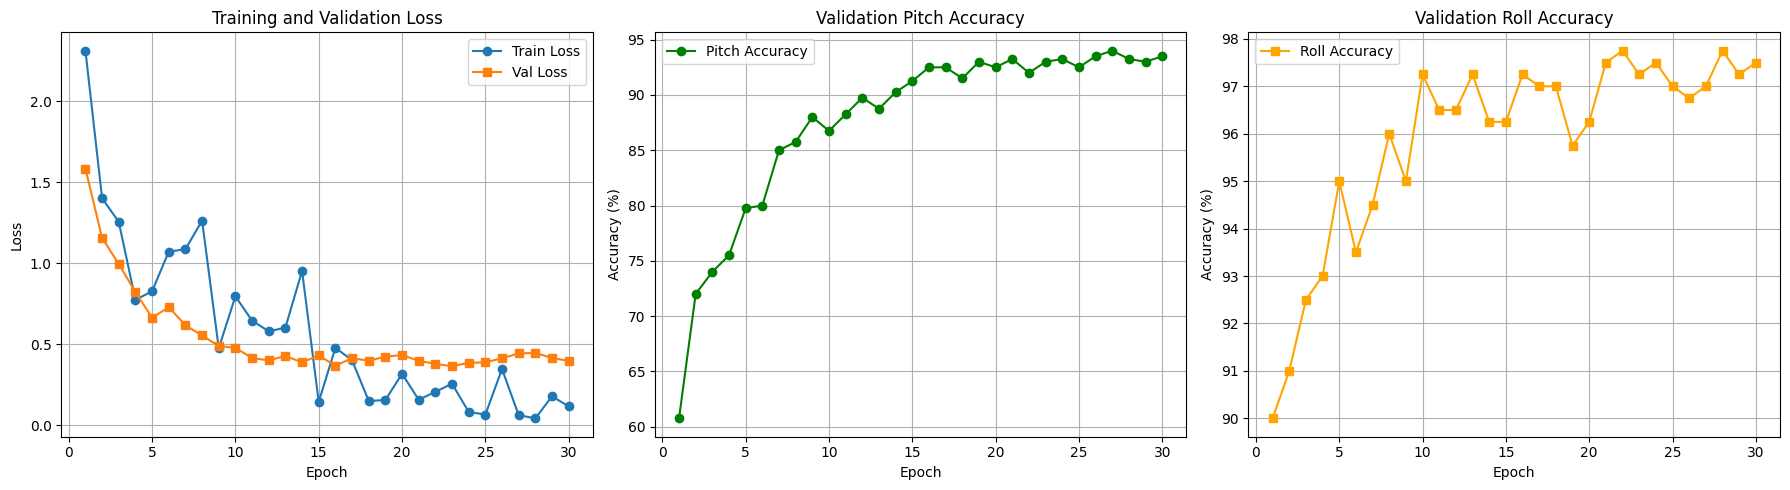

In [76]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss plot
axes[0].plot(range(1, num_epochs+1), train_losses, label='Train Loss', marker='o')
axes[0].plot(range(1, num_epochs+1), val_losses, label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Pitch accuracy plot
axes[1].plot(range(1, num_epochs+1), val_pitch_accs, label='Pitch Accuracy', marker='o', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Validation Pitch Accuracy')
axes[1].legend()
axes[1].grid(True)

# Roll accuracy plot
axes[2].plot(range(1, num_epochs+1), val_roll_accs, label='Roll Accuracy', marker='s', color='orange')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy (%)')
axes[2].set_title('Validation Roll Accuracy')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [77]:
# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_pitch_acc, test_roll_acc, pitch_preds, pitch_labels, roll_preds, roll_labels = evaluate(model, test_loader, criterion, device)

print(f"\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Pitch Accuracy: {test_pitch_acc:.2f}%")
print(f"Roll Accuracy: {test_roll_acc:.2f}%")
print(f"Combined Accuracy (both correct): {100 * sum([1 for p, r, pl, rl in zip(pitch_preds, roll_preds, pitch_labels, roll_labels) if p == pl and r == rl]) / len(pitch_preds):.2f}%")

Evaluating on test set...

Test Results:
Test Loss: 0.2876
Pitch Accuracy: 95.75%
Roll Accuracy: 96.50%
Combined Accuracy (both correct): 92.25%


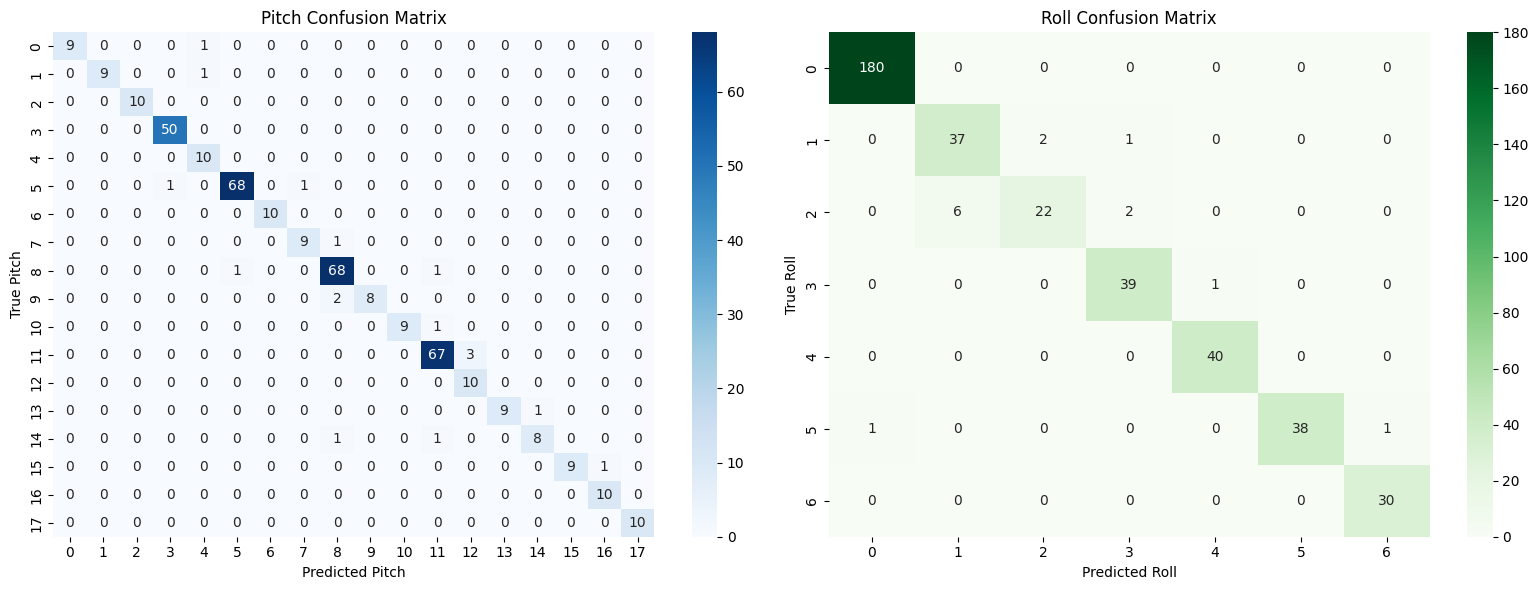

In [78]:
from sklearn.metrics import confusion_matrix, classification_report

# Create confusion matrices
pitch_cm = confusion_matrix(pitch_labels, pitch_preds)
roll_cm = confusion_matrix(roll_labels, roll_preds)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pitch confusion matrix
sns.heatmap(pitch_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Pitch Confusion Matrix')
axes[0].set_xlabel('Predicted Pitch')
axes[0].set_ylabel('True Pitch')

# Roll confusion matrix
sns.heatmap(roll_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Roll Confusion Matrix')
axes[1].set_xlabel('Predicted Roll')
axes[1].set_ylabel('True Roll')

plt.tight_layout()
plt.show()

In [79]:
# Print classification reports
print("=" * 60)
print("PITCH CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(pitch_labels, pitch_preds))

print("\n" + "=" * 60)
print("ROLL CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(roll_labels, roll_preds))

PITCH CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.90      0.95        10
           2       1.00      1.00      1.00        10
           3       0.98      1.00      0.99        50
           4       0.83      1.00      0.91        10
           5       0.99      0.97      0.98        70
           6       1.00      1.00      1.00        10
           7       0.90      0.90      0.90        10
           8       0.94      0.97      0.96        70
           9       1.00      0.80      0.89        10
          10       1.00      0.90      0.95        10
          11       0.96      0.96      0.96        70
          12       0.77      1.00      0.87        10
          13       1.00      0.90      0.95        10
          14       0.89      0.80      0.84        10
          15       1.00      0.90      0.95        10
          16       0.91      1.00      0.95        10

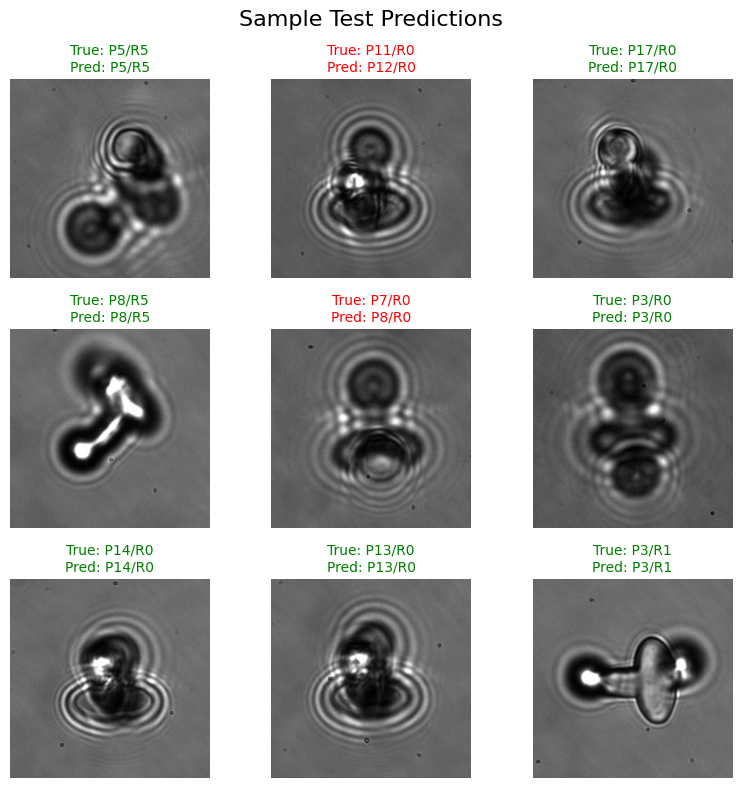

In [80]:
# Visualize sample predictions
num_samples = 9
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
fig.suptitle('Sample Test Predictions', fontsize=16)

# Get a batch from test set
test_images, test_labels_batch = next(iter(test_loader))
test_images = test_images.to(device)

# Get predictions
model.eval()
with torch.no_grad():
    pitch_logits, roll_logits = model(test_images)
    pitch_pred_batch = torch.argmax(pitch_logits, dim=1).cpu().numpy()
    roll_pred_batch = torch.argmax(roll_logits, dim=1).cpu().numpy()

# Plot samples
for idx in range(num_samples):
    row = idx // 3
    col = idx % 3
    
    # Get image and labels
    img = test_images[idx].cpu().permute(1, 2, 0).numpy()
    true_pitch = test_labels_batch[0][idx].item()
    true_roll = test_labels_batch[1][idx].item()
    pred_pitch = pitch_pred_batch[idx]
    pred_roll = roll_pred_batch[idx]
    
    # Plot
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    
    # Color: green if correct, red if wrong
    pitch_correct = pred_pitch == true_pitch
    roll_correct = pred_roll == true_roll
    color = 'green' if (pitch_correct and roll_correct) else 'red'
    
    title = f"True: P{true_pitch}/R{true_roll}\nPred: P{pred_pitch}/R{roll_pred_batch[idx]}"
    axes[row, col].set_title(title, fontsize=10, color=color)

plt.tight_layout()
plt.show()